<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Insights/blob/main/Tunnel/00-GPU-Utilize-GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

성능 모니터링 시스템 테스트: 실제 부하 없이 모니터링 대시보드나 알림 시스템이 올바르게 작동하는지 테스트.

자원 스케줄링 알고리즘 개발: GPU/CPU 사용량 패턴을 예측하고 최적의 작업을 할당하는 알고리즘을 훈련하고 평가.

이상 감지 모델 훈련: 정상 및 비정상 사용량 패턴을 정의하여 이상 감지 모델을 훈련.

벤치마킹 및 시나리오 분석: 특정 워크로드에 대한 시스템의 반응을 시뮬레이션.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_synthetic_gpu_data(start_time, duration_seconds, scenario_type):
    timestamps = [start_time + timedelta(seconds=i) for i in range(duration_seconds)]

    cpu_util = []
    gpu_util = []
    gpu_mem_used = [] # MB 단위

    if scenario_type == "ml_training":
        # ML 학습: GPU 집중, CPU는 보조
        for i in range(duration_seconds):
            if 2 < i < duration_seconds - 2: # 학습 구간
                cpu_util.append(np.clip(np.random.normal(40, 5), 10, 60))
                gpu_util.append(np.clip(np.random.normal(90, 5), 70, 100))
                gpu_mem_used.append(np.clip(np.random.normal(8000, 500), 5000, 22000))
            else: # 시작/종료 시점
                cpu_util.append(np.clip(np.random.normal(20, 5), 5, 30))
                gpu_util.append(np.clip(np.random.normal(10, 5), 0, 30))
                gpu_mem_used.append(np.clip(np.random.normal(500, 100), 100, 2000))

    #  'load'로 변경했습니다.
    elif scenario_type == "load":
        # 게임 플레이 또는 일반적인 높은 부하: CPU/GPU 균형
        for i in range(duration_seconds):
            if 1 < i < duration_seconds - 1: # 부하 발생 구간
                cpu_util.append(np.clip(np.random.normal(40, 8), 20, 80))
                gpu_util.append(np.clip(np.random.normal(75, 10), 50, 95))
                gpu_mem_used.append(np.clip(np.random.normal(6000, 800), 3000, 10000))
            else: # 유휴/종료 시점
                cpu_util.append(np.clip(np.random.normal(15, 5), 5, 30))
                gpu_util.append(np.clip(np.random.normal(10, 5), 0, 20))
                gpu_mem_used.append(np.clip(np.random.normal(1000, 200), 100, 3000))

    elif scenario_type == "idle":
        # 유휴 상태
        for i in range(duration_seconds):
            cpu_util.append(np.clip(np.random.normal(10, 3), 0, 20))
            gpu_util.append(np.clip(np.random.normal(3, 2), 0, 10))
            gpu_mem_used.append(np.clip(np.random.normal(300, 50), 100, 800))

    else:
        raise ValueError("Invalid scenario_type")

    data = {
        "timestamp": timestamps,
        "cpu_utilization_percent": cpu_util,
        "gpu_utilization_percent": gpu_util,
        "gpu_memory_used_mb": gpu_mem_used
    }
    return pd.DataFrame(data)

# 예시 데이터 생성
start_time = datetime(2025, 7, 29, 8, 0, 0)
ml_data = generate_synthetic_gpu_data(start_time, 10, "ml_training")
load_data = generate_synthetic_gpu_data(start_time, 10, "load") # 'gaming' 대신 'load' 사용
idle_data = generate_synthetic_gpu_data(start_time, 10, "idle")

print("--- ML Training Scenario ---")
print(ml_data)
print("\n--- Load Scenario (formerly Gaming) ---")
print(load_data)
print("\n--- Idle Scenario ---")
print(idle_data)

In [3]:
"""
이 스크립트는 GPU 및 CPU의 자원 사용률 시계열 데이터를 시뮬레이션하여 Pandas DataFrame으로 생성합니다.

# [데이터 개요]
- 관찰 기간: **3시간(10,800초, 1초 단위)**
- 시작 시각: 2025-07-29 08:00:00
- 시나리오 유형:
    - **"ml_training"**: 인공지능/머신러닝 학습 작업 환경
    - **"load"**: 고부하 작업(예: 게임 플레이, 대용량 처리)
    - **"idle"**: 시스템 유휴/대기 상태

# [생성되는 DataFrame 구조]
| 컬럼명                   | 설명                     | 예시 값       |
|--------------------------|--------------------------|--------------|
| timestamp                | 시간 정보                | 2025-07-29 08:00:00 |
| cpu_utilization_percent  | CPU 사용률 (%)           | 17.5         |
| gpu_utilization_percent  | GPU 사용률 (%)           | 92.2         |
| gpu_memory_used_mb       | GPU 메모리 사용량 (MB)   | 8100         |

# [시나리오별 특성 요약]

| 시나리오      | CPU 사용률         | GPU 사용률        | GPU 메모리 사용량  |
|---------------|--------------------|-------------------|--------------------|
| ml_training   | 40~60%(학습중)     | 90~100%(집중)     | 8000~22000MB(고)   |
| load          | 40~80%(균형 부하)  | 75~95%(높음)      | 6000~10000MB(높음) |
| idle          | 0~20%(낮음)        | 0~10%(낮음)       | 100~800MB(매우 낮음)|

- **각 시나리오마다 시작/종료 직전 구간은 부하가 낮고, 주요 구간에서 높은 자원 사용률이 지속적으로 기록됩니다.**
- 데이터 값은 현실적 분포를 반영하여 정규분포에서 랜덤 샘플링(`np.random.normal`) 후 적절한 범위(`np.clip`)로 제한됩니다.

# [활용 예시]
- 서버/워크스테이션 모니터링 알고리즘 테스트
- 시계열 이상탐지, 자원 사용 예측 모델 학습
- 대시보드/시각화용 샘플 데이터

# [예시 코드]
"""
start_time = datetime(2025, 7, 29, 8, 0, 0)
ml_data   = generate_synthetic_gpu_data(start_time, 10800, "ml_training")
load_data = generate_synthetic_gpu_data(start_time, 10800, "load")
idle_data = generate_synthetic_gpu_data(start_time, 10800, "idle")
print(ml_data.head())


            timestamp  cpu_utilization_percent  gpu_utilization_percent  \
0 2025-07-29 08:00:00                27.545296                23.472651   
1 2025-07-29 08:00:01                12.560830                 7.676223   
2 2025-07-29 08:00:02                25.344711                14.622315   
3 2025-07-29 08:00:03                43.234425                87.313879   
4 2025-07-29 08:00:04                32.356182                89.338648   

   gpu_memory_used_mb  
0          502.047418  
1          514.905189  
2          488.276689  
3         8972.022707  
4         8678.773845  


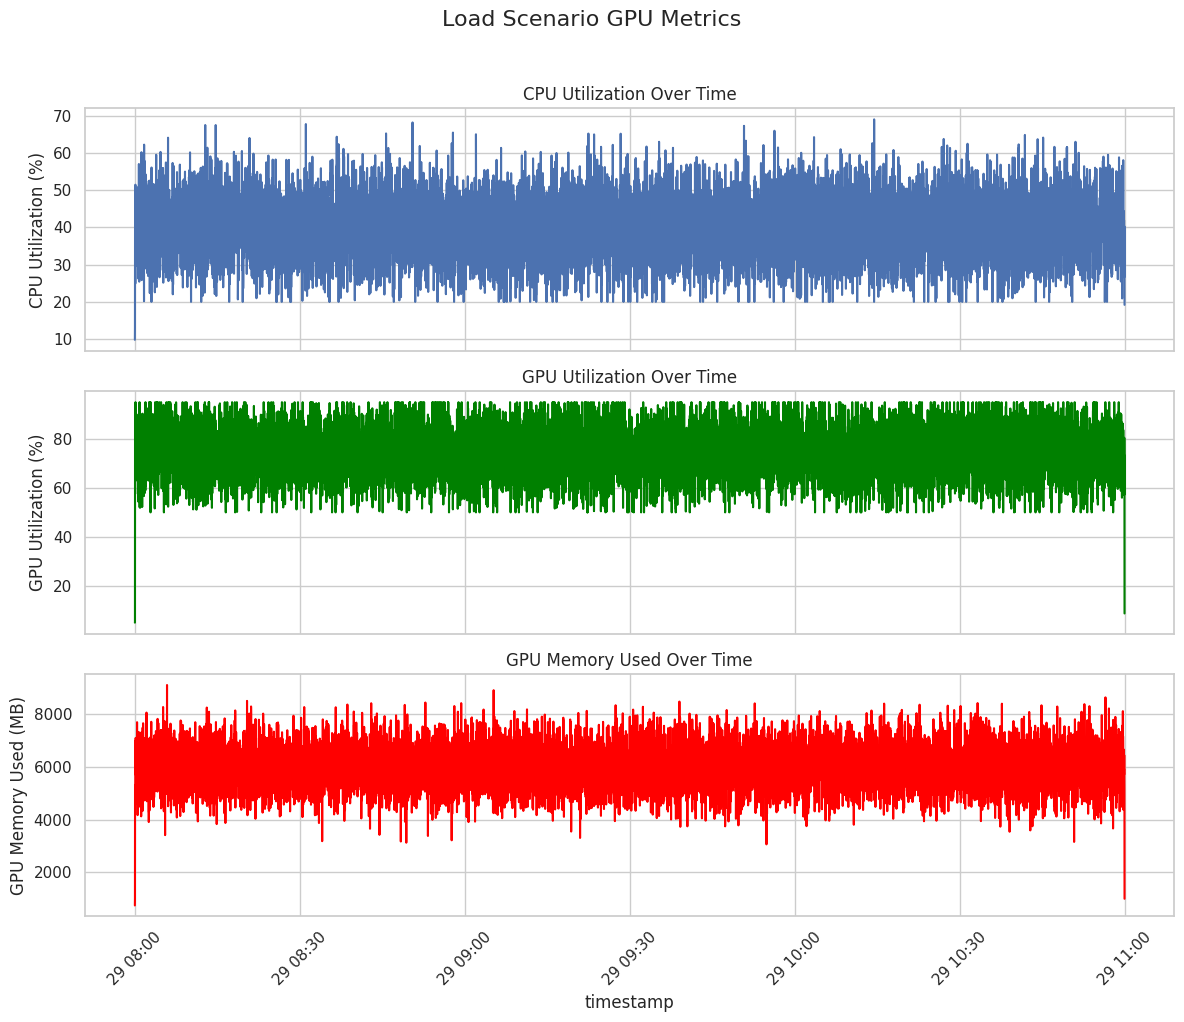

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def plot_gpu_data(df, title):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, y=1.02, fontsize=16)

    # CPU Utilization
    sns.lineplot(ax=axes[0], x="timestamp", y="cpu_utilization_percent", data=df)
    axes[0].set_ylabel("CPU Utilization (%)")
    axes[0].set_title("CPU Utilization Over Time")

    # GPU Utilization
    sns.lineplot(ax=axes[1], x="timestamp", y="gpu_utilization_percent", data=df, color='green')
    axes[1].set_ylabel("GPU Utilization (%)")
    axes[1].set_title("GPU Utilization Over Time")

    # GPU Memory Used
    sns.lineplot(ax=axes[2], x="timestamp", y="gpu_memory_used_mb", data=df, color='red')
    axes[2].set_ylabel("GPU Memory Used (MB)")
    axes[2].set_title("GPU Memory Used Over Time")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plotting the data for the load scenario
plot_gpu_data(load_data, "Load Scenario GPU Metrics")

GPU/CPU 사용량 패턴을 예측하고 이를 기반으로 부하 분산(Load Balancing)을 최적화하는 데 **강화 학습(Reinforcement Learning, RL)**  **GRPO(Group Relative Policy Optimization)**와 같은 알고리즘 활용
### 강화 학습(RL)의 GPU/CPU 부하 분산 적용 가능성

강화 학습은 에이전트(Agent)가 환경(Environment)과 상호작용하면서 보상(Reward)을 최대화하는 정책(Policy)을 학습하는 방식입니다. GPU/CPU 부하 분산에 적용할 경우:

* **환경(Environment):** 현재 시스템의 GPU 및 CPU 사용률, 메모리 사용량, 각 작업의 특성(CPU-intensive, GPU-intensive, 메모리-intensive), 대기 큐의 길이 등이 환경의 상태(State)가 될 수 있습니다.
* **에이전트(Agent):** 부하 분산 결정을 내리는 주체입니다.
* **행동(Action):** 특정 작업을 어떤 GPU 또는 CPU 코어에 할당할지, 작업의 우선순위를 어떻게 조절할지, 또는 작업을 다른 노드로 마이그레이션할지 등의 결정이 될 수 있습니다.
* **보상(Reward):** 부하 분산의 목표에 따라 정의됩니다. 예를 들어:
    * 총 작업 완료 시간 최소화 (throughput 최대화)
    * GPU/CPU 활용률 균등화 (자원 낭비 최소화)
    * 전력 소비량 최소화
    * 지연 시간(latency) 최소화
    * 시스템 안정성 유지 (과부하 방지)

에이전트는 이 보상을 최대화하도록 학습하며, GPU/CPU 사용량 패턴 예측은 이러한 의사결정을 내리는 데 중요한 입력 정보가 됩니다.

### GRPO와 같은 RL 알고리즘의 역할

GRPO는 특히 대규모 언어 모델(LLM) 학습에 효과적이라고 알려져 있지만, 그 핵심 아이디어인 **정책 최적화**와 **메모리 효율성**은 자원 관리 문제에도 적용될 여지가 있습니다.

GRPO의 주요 특징과 부하 분산 적용 아이디어는 다음과 같습니다:

1.  **정책 최적화:** GRPO는 여러 가능한 행동(예: 작업 할당 방식)을 시도하고, 그 결과(시스템 상태 변화 및 보상)를 평가하여 최적의 정책을 찾아나갑니다. GPU/CPU 부하 분산의 맥락에서는 "현재 상태에서 다음 작업을 어디에 할당하는 것이 가장 높은 보상을 가져올까?"를 학습하는 것입니다.
2.  **그룹 상대적 장점 (Group Relative Advantage):** GRPO는 생성된 여러 응답(여기서는 여러 할당 결정)의 평균 보상을 기준으로 개별 응답의 "장점"을 계산합니다. 이는 부하 분산 시 여러 가능한 할당 시나리오를 동시에 고려하고, 상대적으로 더 나은 시나리오를 학습하는 데 활용될 수 있습니다. 예를 들어, N개의 작업을 M개의 디바이스에 할당하는 다양한 경우의 수를 시도하고, 이들 중 가장 효율적인 할당 방식을 찾아낼 수 있습니다.
3.  **메모리 효율성:** GRPO가 LLM 학습에서 메모리 효율성을 강조하는 것처럼, 복잡한 시스템의 자원 관리는 많은 상태와 행동 공간을 가질 수 있습니다. GRPO의 이러한 특성은 대규모 분산 시스템이나 복잡한 워크로드 환경에서 부하 분산 정책을 학습하는 데 이점을 제공할 수 있습니다.
4.  **확장성:** 강화 학습은 본질적으로 동적인 환경에서 작동하며, 시스템의 변화(새로운 작업 유입, 기존 작업 완료, 하드웨어 변경 등)에 적응할 수 있는 정책을 학습할 수 있습니다. 이는 정적 규칙 기반의 부하 분산보다 훨씬 유연하고 강력합니다.

### GPU/CPU 사용량 패턴 예측과의 연계

GPU/CPU 사용량 패턴 예측은 강화 학습 에이전트에게 중요한 **상태 정보**를 제공합니다. 에이전트는 단순히 현재의 사용량뿐만 아니라, 예측된 미래의 사용량 패턴을 고려하여 더 장기적인 최적의 부하 분산 결정을 내릴 수 있습니다. 예를 들어:

* **미래 병목 예측:** 특정 GPU가 곧 과부하 상태가 될 것으로 예측되면, 에이전트는 미리 다른 GPU나 CPU로 작업을 분산하여 병목 현상을 회피할 수 있습니다.
* **자원 활용 극대화:** 유휴 상태가 될 것으로 예측되는 자원이 있다면, 에이전트는 해당 자원에 작업을 선제적으로 할당하여 자원 활용률을 높일 수 있습니다.
* **전력 효율:** 사용량이 줄어들 것으로 예측되는 시간대에는 저전력 모드를 유도하거나, 작업을 한 곳으로 몰아 나머지를 절전 상태로 만드는 결정을 내릴 수 있습니다.

**예측 모델 통합:**
GPU/CPU 사용량 예측은 GRU(Gated Recurrent Unit)나 LSTM(Long Short-Term Memory)과 같은 시계열 예측 모델을 사용하여 수행할 수 있습니다. 이 예측 모델의 출력(예: 향후 5분간의 예상 GPU/CPU 사용률)이 강화 학습 에이전트의 상태 공간에 포함되는 형태가 될 수 있습니다.

### 과제 및 고려사항

* **상태-행동 공간의 복잡성:** GPU/CPU가 많고 작업 종류가 다양할수록 상태 공간과 행동 공간이 매우 커져 학습이 어려워질 수 있습니다. 효과적인 상태 표현(State Representation)과 행동 공간 축소가 중요합니다.
* **보상 함수 설계:** 적절한 보상 함수를 설계하는 것이 매우 중요합니다. 너무 단순하거나 현실적이지 않은 보상 함수는 에이전트가 원하는 방향으로 학습하지 못하게 할 수 있습니다. 여러 목표(성능, 전력, 공정성 등) 간의 균형을 맞추는 것이 어렵습니다.
* **시뮬레이션 환경 구축:** 실제 시스템에서 강화 학습을 직접 시도하는 것은 위험하고 비효율적일 수 있습니다. 위에 언급된 합성 데이터 생성 방법을 활용하여 실제와 유사한 시뮬레이션 환경을 구축하고, 거기서 에이전트를 학습시키는 것이 일반적입니다.
* **실시간 적용:** 학습된 정책을 실제 시스템에 적용할 때는 실시간성 요구사항을 충족해야 합니다. 즉, 에이전트가 충분히 빠르게 결정을 내릴 수 있어야 합니다.
* **비결정성 및 불확실성:** 실제 시스템의 사용량 패턴은 예측 불가능한 요소가 많습니다. 강화 학습 에이전트는 이러한 불확실성에도 강건하게 작동하도록 학습되어야 합니다.

결론적으로, GPU/CPU 사용량 패턴 예측 데이터를 입력으로 하여 GRPO와 같은 강화 학습 알고리즘으로 부하 분산 정책을 학습하는 것은 기술적으로 가능하며, 동적이고 복잡한 시스템 환경에서 매우 강력한 자원 관리 솔루션을 제공할 잠재력이 있습니다. 이는 활발히 연구되고 있는 분야 중 하나입니다.

---
**GRPO(Group Relative Policy Optimization)를 학습하기 위한 합성 데이터(synthetic data) 생성은 가능할 뿐만 아니라, 실제로 매우 중요한 단계입니다.** 강화 학습(Reinforcement Learning, RL) 에이전트를 실제 환경에 바로 투입하여 학습시키는 것은 비용이 많이 들고 위험하며, 학습 과정에서 시스템에 부정적인 영향을 줄 수도 있기 때문입니다.

합성 데이터는 GRPO 에이전트가 다양한 시나리오와 상태를 경험하며 최적의 정책을 학습할 수 있는 **안전하고 제어 가능한 시뮬레이션 환경**을 제공합니다.

### GRPO 학습을 위한 합성 데이터의 종류 및 생성 방법

GRPO를 포함한 대부분의 강화 학습은 '상태(State)', '행동(Action)', '보상(Reward)', '다음 상태(Next State)'의 시퀀스 데이터를 필요로 합니다. 이러한 데이터는 시뮬레이션 환경에서 에이전트가 행동을 취하고 환경이 반응하면서 생성됩니다.

1.  **환경 상태 합성 데이터 (Synthetic Environmental States):**
    * **GPU/CPU 사용량 패턴:** 이전 답변에서 설명했듯이, 특정 시나리오(ML 학습, 게임, 유휴 등)에 따라 GPU/CPU의 활용률, 메모리 사용량, 온도, 전력 소모량 등을 **시계열 데이터** 형태로 생성합니다. 이는 에이전트가 현재 시스템의 '부하 상태'를 인식하는 데 사용됩니다.
    * **작업 큐 상태:** 시스템에 대기 중인 작업들의 수, 각 작업의 특성(예: CPU-intensive, GPU-intensive, 예상 실행 시간), 우선순위 등을 무작위 또는 규칙 기반으로 생성합니다.
    * **네트워크 지연/대역폭:** 분산 환경의 경우, 노드 간의 네트워크 지연이나 대역폭 변화를 시뮬레이션하여 에이전트가 이를 고려한 부하 분산 결정을 내리도록 할 수 있습니다.

    **생성 방법:**
    * **확률 분포:** 정규 분포, 푸아송 분포 등을 사용하여 특정 지표의 무작위 변동을 모델링합니다.
    * **시계열 모델:** ARIMA, LSTM, GAN 등을 사용하여 실제 관측된 패턴을 모방하거나 새로운 패턴을 생성합니다.
    * **규칙 기반 시뮬레이터:** "GPU 사용량이 90%를 넘으면 새로운 작업 할당을 자제한다"와 같은 규칙을 정의하여 환경의 반응을 시뮬레이션합니다.

2.  **행동 데이터 (Action Data):**
    * GRPO 에이전트가 특정 상태에서 취할 수 있는 가능한 '행동'들을 정의하고, 시뮬레이션 과정에서 에이전트가 이 행동들 중 하나를 선택하도록 합니다.
    * **예시 행동:** 특정 작업을 GPU 1에 할당, 작업을 CPU 코어 3에 할당, 고전력 모드 전환, 저전력 모드 전환, 작업 일시 중지 등.
    * 합성 데이터 자체에 행동이 포함되는 것이 아니라, 시뮬레이션 중에 에이전트가 행동을 생성하고, 이 행동이 환경에 미치는 영향을 데이터로 기록합니다.

3.  **보상 데이터 (Reward Data):**
    * 에이전트가 특정 '상태'에서 '행동'을 취한 후, 환경이 '다음 상태'로 전이되면서 '보상'이 계산됩니다. 이 보상은 에이전트가 학습하고자 하는 목표에 따라 달라집니다.
    * **예시 보상:**
        * **긍정 보상:** 작업 완료 시, GPU/CPU 활용률이 균형을 이룰 때, 전력 소비가 줄어들 때.
        * **부정 보상:** 작업이 시간 초과될 때, 특정 리소스가 과부하될 때, 시스템이 불안정해질 때.
    * 합성 보상은 사전에 정의된 규칙이나 함수에 따라 시뮬레이션 환경에서 계산됩니다. 예를 들어, `reward = - (gpu_util_std_dev + cpu_util_std_dev) - (overload_penalty)`.

### 합성 데이터를 활용한 GRPO 학습 시나리오

1.  **환경 시뮬레이터 구축:** GPU/CPU 사용량, 작업 큐, 전력 소모 등 시스템의 주요 지표와 동작을 모방하는 소프트웨어 시뮬레이터를 개발합니다. 이 시뮬레이터는 에이전트의 '행동'에 따라 '환경 상태'를 업데이트하고 '보상'을 계산합니다.
2.  **초기 상태 생성:** 다양한 초기 시스템 부하 상태(예: 유휴 상태, 중간 부하 상태, 거의 과부하 상태)를 나타내는 합성 데이터를 생성하여 시뮬레이터를 시작합니다.
3.  **에이전트-환경 상호작용:**
    * 에이전트(GRPO 모델)는 시뮬레이터가 제공하는 현재 상태 합성 데이터를 입력받습니다.
    * 에이전트는 학습된 정책에 따라 '행동'을 결정합니다.
    * 시뮬레이터는 이 '행동'을 수행한 결과로 '다음 상태' 합성 데이터를 생성하고, '보상'을 계산하여 에이전트에게 반환합니다.
    * 이 과정이 반복되면서(에피소드) 에이전트는 다양한 경험 데이터(상태, 행동, 보상, 다음 상태)를 축적하고, 이를 기반으로 GRPO 알고리즘을 통해 정책을 업데이트합니다.
4.  **다양한 워크로드 시뮬레이션:** ML 학습, 렌더링, 웹 서비스 등 다양한 유형의 가상 워크로드를 합성 데이터로 정의하고 시뮬레이터에 주입하여, 에이전트가 여러 환경에서 강건하게 작동하도록 학습시킬 수 있습니다.

### 왜 합성 데이터가 필수적인가?

* **안전성:** 실제 운영 시스템에 영향을 주지 않고 복잡한 부하 분산 전략을 테스트하고 학습할 수 있습니다.
* **재현성:** 동일한 시뮬레이션 환경과 초기 상태를 반복하여 에이전트의 학습 과정을 정확히 재현하고 디버깅할 수 있습니다.
* **다양성:** 실제로는 발생하기 어려운 극한 상황(예: 갑작스러운 대규모 부하 급증, 여러 자원의 동시 장애)을 인위적으로 생성하여 에이전트가 이에 대처하는 방법을 학습할 수 있습니다.
* **비용 효율성:** 값비싼 실제 하드웨어나 클라우드 자원을 사용하지 않고 학습을 진행할 수 있습니다.
* **데이터 부족 문제 해결:** 실제 환경에서 충분한 학습 데이터를 얻기 어려운 경우, 합성 데이터를 통해 데이터 부족 문제를 해소할 수 있습니다.

따라서 GRPO와 같은 강화 학습 모델을 GPU/CPU 부하 분산에 적용하기 위해서는, 대상 시스템의 특성을 반영하는 **정교한 합성 데이터 생성 및 시뮬레이션 환경 구축이 선행되어야 합니다.** 이는 학습의 효율성과 실제 환경에서의 성공적인 적용 가능성을 크게 좌우하는 요소입니다.